In [29]:
import pandas as pd
import numpy as np
import torch
from torch import cuda
import random
import os
import re
import torch
from torch import nn
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from matplotlib import pyplot as plt
print(torch.__version__)


1.11.0+cu113


In [30]:
# data import
#Training_data
train_data = pd.read_csv(r"/content/train.csv")
#test data import
test_data = pd.read_csv(r"/content/test.csv")


In [31]:
#Print out the columns name and remove the header
print(train_data.columns)
train_data.head(5)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [32]:
#create Target
train_label = train_data.target.to_numpy()
y_train = train_label.reshape(-1)
train_data.drop(['id', 'keyword', 'location', 'target'], axis=1, inplace=True)
test_data.drop(['id', 'keyword', 'location'], axis=1, inplace=True)
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()
x_train = train_data.reshape(-1)
x_test = test_data.reshape(-1)
print(x_train)
print(y_train)

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 ... 'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ'
 'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.'
 'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d']
[1 1 1 ... 1 1 1]


In [33]:
#Data clearning
def clean_tweet(tweet):
  #remove apostrophe
  tweet = re.sub(r'\x89Ûª', "'", tweet)
  tweet = re.sub(r'\x89Û÷', "'", tweet)
  #remove quotation
  tweet = re.sub(r'\x89ÛÏ', '"', tweet)
  tweet = re.sub(r'\x89Û\x9d', '"', tweet)
  #remove hyphen
  tweet = re.sub(r'\x89ÛÒ', '-', tweet)
  tweet = re.sub(r'\x89ÛÓ', '—', tweet)
  #remove euro
  tweet = re.sub(r'\x89âÂ', '€', tweet)
  #remove ellipsis
  tweet = re.sub(r'\x89Û_', '...', tweet)
  #remove amp
  tweet = re.sub(r'&', 'and', tweet)
  #remove bullet
  tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
  tweet = re.sub(r'\x89Û¢', '', tweet)
  #remove others
  tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
  tweet = re.sub(r"åÊ", "", tweet)
  tweet = re.sub(r"åÈ", "", tweet)
  tweet = re.sub(r"JapÌ_n", "Japan", tweet)
  tweet = re.sub(r"Ì©", "e", tweet)
  tweet = re.sub(r"å¨", "", tweet)
  tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
  tweet = re.sub(r"åÇ", "", tweet)
  tweet = re.sub(r"å£3million", "3 million ", tweet)
  tweet = re.sub(r"åÀ", "", tweet)
  return tweet
#remove URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'This is a website.',text)
#remove html
def remove_html(text):
  html=re.compile(r'<.*?>')
  return html.sub(r'',text)
#remove emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [34]:
#Normalization 
def custom_standardization(input_data):
    r = clean_tweet(input_data)
    r = remove_URL(r)
    r = remove_html(r)
    r = remove_emoji(r)
    r = str.lower(r)
    return r  
all_tweets = np.append(x_train, x_test)
def normalization(tweets):
    result = []
    for tweet in tweets:
        result.append(custom_standardization(tweet))
    return result

all_tweets = normalization(all_tweets)

In [35]:
#Model constant
max_features = 20000
embedding_dim = 128
max_len = 500
#Textvectorization
from keras.layers import*
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=max_len)
#Make a text-only dataset (no labels)
vectorize_layer.adapt(all_tweets)
#import tensorflow 
import tensorflow as tf
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [36]:
# Start to build bidirection LSTM model
from keras.metrics import AUC
from keras import optimizers, losses
def build_model():

    text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
    x = vectorize_layer(text_input)
    x = Embedding(max_features + 1, embedding_dim)(x)
    x = Dropout(0.5)(x)
    #Bidirection LSTM
    x1 = Bidirectional(LSTM(units=128, return_sequences=True))(x)
    x2 = Bidirectional(LSTM(units=64, return_sequences=True))(x1)
    #GRU
    z2 = Bidirectional(GRU(units=128, return_sequences=True))(x)
    z3 = Bidirectional(GRU(units=64, return_sequences=True))(z2)
    c = Concatenate(axis=2)([x2, z3])
    x3 = Bidirectional(LSTM(units=128, return_sequences=True))(c)
    #Using Global Maxpooling
    x = GlobalMaxPooling1D()(x3)
    # Add a vanilla hidden layer:
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    # We project onto a single unit output layer, and squash it with a sigmoid:
    predictions = Dense(1, activation="sigmoid", name="predictions")(x)
    model = tf.keras.Model(text_input, predictions)
    # Compile the model with binary crossentropy loss and an adam optimizer.
    model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.rmsprop_v2.RMSprop(learning_rate=0.01), metrics=[AUC(name = 'auc')])
    return model

In [37]:
model = build_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_3 (TextVect  (None, 500)         0           ['text[0][0]']                   
 orization)                                                                                       
                                                                                                  
 embedding_2 (Embedding)        (None, 500, 128)     2560128     ['text_vectorization_3[0][0]']   
                                                                                                  
 dropout_4 (Dropout)            (None, 500, 128)     0           ['embedding_2[0][0]']      

In [38]:
#Split the training set into 2 part, train and valid
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [39]:
from keras.callbacks import *

lr = ReduceLROnPlateau(monitor="val_auc", mode='max', factor=0.7, patience=4, verbose=False)
es = EarlyStopping(monitor='val_auc',mode='max', patience=10, verbose=False,restore_best_weights=True)

history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=4, batch_size=256,
                    callbacks=[es,lr])

Epoch 1/4
24/24 [==============================] - 31s 708ms/step - loss: 1.3735 - auc: 0.4952 - val_loss: 0.6812 - val_auc: 0.5000 - lr: 0.0100
Epoch 2/4
24/24 [==============================] - 14s 582ms/step - loss: 0.6880 - auc: 0.4949 - val_loss: 0.6830 - val_auc: 0.5191 - lr: 0.0100
Epoch 3/4
24/24 [==============================] - 14s 580ms/step - loss: 0.6565 - auc: 0.6481 - val_loss: 0.6216 - val_auc: 0.7209 - lr: 0.0100
Epoch 4/4
24/24 [==============================] - 14s 570ms/step - loss: 0.4733 - auc: 0.8393 - val_loss: 0.5404 - val_auc: 0.7919 - lr: 0.0100


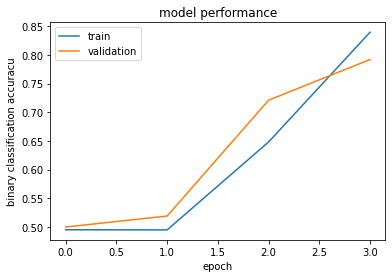

In [40]:
#visulization of the result
def plot_hist(hist, metric='auc'):
    plt.plot(hist.history[metric])
    plt.plot(hist.history["val_" + metric])
    plt.title(f"model performance")
    plt.ylabel("binary classification accuracu")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    return
plot_hist(hist=history)